This Colaboratory notebook shows a working workflow for **Text classification** with the [BERT](https://en.wikipedia.org/wiki/BERT_(language_model) model. It uses a [greek version ](https://huggingface.co/nlpaueb/bert-base-greek-uncased-v1) of a BERT pre-trained language model. Executing the cells one by one will give you a saved model folder that you can use later.

In [5]:
#Check if a GPU is present. If not go to Edit -> Notebook settings and change it to GPU for faster results

!nvidia-smi

Sun May 23 04:27:59 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P0    30W /  70W |   1406MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
#Import neccessary libraries

import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import tensorflow.keras as K
from keras.utils import to_categorical
import numpy as np
import pandas as pd

tf.get_logger().setLevel('ERROR')

In [7]:
print(tf.__version__)
print(K.__version__)

2.4.1
2.4.0


In [ ]:
#Install transformers and download the greek specific file for model and tokenizer from Hugging Face Hub

!pip install transformers
from transformers import AutoTokenizer, TFAutoModel
from transformers import AdamWeightDecay

tokenizer = AutoTokenizer.from_pretrained("nlpaueb/bert-base-greek-uncased-v1")
model = TFAutoModel.from_pretrained("nlpaueb/bert-base-greek-uncased-v1")


In [9]:
#View some info for the model and the tokenizer

model.summary()
print()
model
print()
tokenizer

Model: "tf_bert_model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  112921344 
Total params: 112,921,344
Trainable params: 112,921,344
Non-trainable params: 0
_________________________________________________________________




PreTrainedTokenizerFast(name_or_path='nlpaueb/bert-base-greek-uncased-v1', vocab_size=35000, model_max_len=1000000000000000019884624838656, is_fast=True, padding_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

#GRGE example
We are going to use a .csv file with greek texts from twitter that are divided in 3 categories (Negative, POsitive, Neutral)

In [11]:
df = pd.read_csv("/content/GRGE_sentiment.csv")
print(df)

      Unnamed: 0                                               Text Polarity1
0              0  Επιχείρηση Βολευτική έδρα!  Βασίλης Οικονόμου:...  Negative
1              1  Κ ά β ο ς: Ψηφοδέλτιο ΣΥΡΙΖΑ Κορινθίας - Πού π...  Negative
2              2  @Dora_Bakoyannis Αυτο-καρφώνεσαι όταν αναρωτιέ...  Positive
3              3  Κόμμα «σκαντζόχοιρος»: «Σφαγή» πασοκογενών από...   Neutral
4              4  Και γαμώ και την Νέα Δημοκρατία γιατί ειμαι πο...  Negative
...          ...                                                ...       ...
1635        1635  Κουτσούμπας: Δεν θα γίνουμε κερασάκι στην αντι...  Negative
1636        1636  Θέλουμε μια Ελλάδα με πολιτικούς σαν την κ.Φωτ...  Negative
1637        1637  Για διαχωρισμό κράτους-εκκλησίας, ομόφυλο γάμο...  Negative
1638        1638  ΓΙΑΝΝΕΝΑ:Στην πρώτη γραμμή της προεκλογικής μά...   Neutral
1639        1639  Σημαντικό βήμα για την αποφυγή της επερχόμενης...   Neutral

[1640 rows x 3 columns]


In [12]:
#View frst 10 entries

text_list = df['Text'].to_list()
print(text_list[:10])
polarity = df["Polarity1"].to_list()
print(polarity[:10])

['Επιχείρηση Βολευτική έδρα!  Βασίλης Οικονόμου:  Από το ΠΑΣΟΚ διαγράφηκε απο το ΓΑΠ επειδη ΔΕΝ ψήφισε το Μνημόνιο... http://t.co/gPgr1Caqxv', 'Κ ά β ο ς: Ψηφοδέλτιο ΣΥΡΙΖΑ Κορινθίας - Πού πας,ΣΥΡΙΖΑ, με δράμι μυαλό... http://t.co/8eIiKYS7CP', '@Dora_Bakoyannis Αυτο-καρφώνεσαι όταν αναρωτιέσαι ποιον ΠτΔ θα προτείνει ο ΣΥΡΙΖΑ  αποδεχόμενη την νίκη του αντιπάλου.', 'Κόμμα «σκαντζόχοιρος»: «Σφαγή» πασοκογενών από τις λίστες του ΣΥΡΙΖΑ http://t.co/rC7EY67qFY', 'Και γαμώ και την Νέα Δημοκρατία γιατί ειμαι πολιτικο ακκάουντ στην τελική όχι κλαψομούνικο!!!!', 'Ε. Καϊλή: «Ηθικό ζήτημα που θα κριθεί από τον κόσμο» η μετακίνηση της Γκερέκου στη ΝΔ http://t.co/Q4oYSfJjZZ', 'ΔΙΑΒΑΣΤΕ ΣΗΜΕΡΑ ΣΤΗΝ KONTRA NEWS : ΣΙΓΟΥΡΗ ΠΛΕΟΝ Η ΑΥΤΟΔΥΝΑΜΙΑ ΤΟΥ ΣΥΡΙΖΑ ΚΑΘΑΡΙΣΕ Ο ΣΑΜΑΡΑΣ ΓΙΑ ΤΟΝ ΑΛΕΞΗ ΔΥΟ... http://t.co/JZV7IHUTw1', 'Συμφωνεί ο ΣΥΡΙΖΑ στα Εθνικά θέματα με τον Τρεμόπουλο; Ο “οικολόγος” Μιχ. Τρεμόπουλος, εκείνος που είχε αναφέρ... http://t.co/nqFAZKAQO5', 'Τα μέτρα του ΣΥΡΙΖΑ ενάντια στη διαπλοκή http://

In [15]:
# Prepare input data for training

def my_func(arg):
  arg = tf.convert_to_tensor(arg, dtype=tf.string)
  return arg

train_x = my_func(np.array(text_list))
print(train_x[:2])

tf.Tensor(
[b'\xce\x95\xcf\x80\xce\xb9\xcf\x87\xce\xb5\xce\xaf\xcf\x81\xce\xb7\xcf\x83\xce\xb7 \xce\x92\xce\xbf\xce\xbb\xce\xb5\xcf\x85\xcf\x84\xce\xb9\xce\xba\xce\xae \xce\xad\xce\xb4\xcf\x81\xce\xb1!  \xce\x92\xce\xb1\xcf\x83\xce\xaf\xce\xbb\xce\xb7\xcf\x82 \xce\x9f\xce\xb9\xce\xba\xce\xbf\xce\xbd\xcf\x8c\xce\xbc\xce\xbf\xcf\x85:  \xce\x91\xcf\x80\xcf\x8c \xcf\x84\xce\xbf \xce\xa0\xce\x91\xce\xa3\xce\x9f\xce\x9a \xce\xb4\xce\xb9\xce\xb1\xce\xb3\xcf\x81\xce\xac\xcf\x86\xce\xb7\xce\xba\xce\xb5 \xce\xb1\xcf\x80\xce\xbf \xcf\x84\xce\xbf \xce\x93\xce\x91\xce\xa0 \xce\xb5\xcf\x80\xce\xb5\xce\xb9\xce\xb4\xce\xb7 \xce\x94\xce\x95\xce\x9d \xcf\x88\xce\xae\xcf\x86\xce\xb9\xcf\x83\xce\xb5 \xcf\x84\xce\xbf \xce\x9c\xce\xbd\xce\xb7\xce\xbc\xcf\x8c\xce\xbd\xce\xb9\xce\xbf... http://t.co/gPgr1Caqxv'
 b'\xce\x9a \xce\xac \xce\xb2 \xce\xbf \xcf\x82: \xce\xa8\xce\xb7\xcf\x86\xce\xbf\xce\xb4\xce\xad\xce\xbb\xcf\x84\xce\xb9\xce\xbf \xce\xa3\xce\xa5\xce\xa1\xce\x99\xce\x96\xce\x91 \xce\x9a\xce\xbf\xcf\x8

In [16]:
#Prepare labels for training

encoded_labels = []
for i in polarity:
  if i == 'Negative':
    encoded_labels.append(0)
  elif i == 'Positive':
    encoded_labels.append(1)
  elif i == 'Neutral':
    encoded_labels.append(2)
    
print(encoded_labels[:4])
print(len(encoded_labels))

transformed_encoded_labels = np.array(encoded_labels)
print(transformed_encoded_labels[:4])

[0, 0, 1, 2]
1640
[0 0 1 2]


In [17]:
#Convert labels to categorical and then to tensor

labels_split_categorical = to_categorical(encoded_labels)
print(labels_split_categorical)

# Prepare the labels data
def my_func_float(arg):
  arg = tf.convert_to_tensor(arg, dtype=tf.float32)
  return arg

train_labels = my_func_float(labels_split_categorical) 
print(train_labels)

[[1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 ...
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]]
tf.Tensor(
[[1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 ...
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]], shape=(1640, 3), dtype=float32)


#Models

In [18]:
tfhub_handle_encoder = model
tfhub_handle_preprocess = tokenizer

print(f'BERT model selected: {tfhub_handle_encoder}')
print(f'Preprocess model: {tfhub_handle_preprocess}')

BERT model selected: <transformers.models.bert.modeling_tf_bert.TFBertModel object at 0x7f23ef3940d0>
Preprocess model: PreTrainedTokenizerFast(name_or_path='nlpaueb/bert-base-greek-uncased-v1', vocab_size=35000, model_max_len=1000000000000000019884624838656, is_fast=True, padding_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


In [19]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)
bert_model = hub.KerasLayer(tfhub_handle_encoder)

#Test an input to the model

In [22]:
text_test = ['αυτή ήταν μια φανταστική ταινία!']
text_preprocessed = bert_preprocess_model(text_test)
#text_preprocessed = tokenizer.encode(text_test)
print(text_preprocessed)
print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'input_ids      : {text_preprocessed["input_ids"][0]}')
print(f'attention_mask   : {text_preprocessed["attention_mask"][0][:12]}')
print(f'token_type_ids   : {text_preprocessed["token_type_ids"][0][:12]}')


{'input_ids': [[101, 393, 384, 369, 12859, 1146, 108, 102]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1]]}
Keys       : ['input_ids', 'token_type_ids', 'attention_mask']
input_ids      : [101, 393, 384, 369, 12859, 1146, 108, 102]
attention_mask   : [1, 1, 1, 1, 1, 1, 1, 1]
token_type_ids   : [0, 0, 0, 0, 0, 0, 0, 0]


In [23]:
# Prepare input to be used from the model
# Generate a dictionary of tensor inputs

def my_func(arg):
  arg = tf.convert_to_tensor(arg, dtype=tf.int32)
  return arg

transformed_text = {'input_ids': my_func(text_preprocessed["input_ids"]), 'token_type_ids': my_func(text_preprocessed["token_type_ids"]), 'attention_mask': my_func(text_preprocessed["attention_mask"])}
print(transformed_text)

{'input_ids': <tf.Tensor: shape=(1, 8), dtype=int32, numpy=
array([[  101,   393,   384,   369, 12859,  1146,   108,   102]],
      dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(1, 8), dtype=int32, numpy=array([[0, 0, 0, 0, 0, 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(1, 8), dtype=int32, numpy=array([[1, 1, 1, 1, 1, 1, 1, 1]], dtype=int32)>}


In [26]:
# Get the result of the model after passing the dictionary

bert_results = bert_model(transformed_text)
#print(bert_results)
print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Keys       : {list(bert_results.keys())}')
print(f'Pooled Output Shape:{bert_results["pooler_output"].shape}')
print(f'Pooled Output Values:{bert_results["pooler_output"][0, :12]}')
print(f'Sequence Output Shape:{bert_results["last_hidden_state"].shape}')
print(f'Sequence Output Values:{bert_results["last_hidden_state"][0, :12]}')

Loaded BERT: <transformers.models.bert.modeling_tf_bert.TFBertModel object at 0x7f23ef3940d0>
Keys       : ['last_hidden_state', 'pooler_output']
Pooled Output Shape:(1, 768)
Pooled Output Values:[-0.7756876  -0.48410642  0.10253016  0.621603   -0.46155113  0.10883062
  0.961941    0.41196406  0.6992992  -0.42222884 -0.2164939  -0.2050891 ]
Sequence Output Shape:(1, 8, 768)
Sequence Output Values:[[-0.95883304 -0.26517636  0.12192754 ... -0.74791586  0.35750234
   1.0346323 ]
 [-1.3804331   0.2030597  -0.02667625 ...  1.0282251   0.3847218
  -2.057902  ]
 [-0.9816262   0.25108054  1.1753194  ... -0.28084525  0.37680596
  -0.6475431 ]
 ...
 [-1.4601182   0.45342112 -0.0151363  ...  0.8060957  -0.05657317
  -1.1681705 ]
 [-1.0056059  -0.18209678 -0.11410159 ...  0.5029514  -0.15278082
   0.19413413]
 [-0.07957786  0.1275501   1.0447783  ... -0.039065    0.3833198
   0.3138709 ]]


#Encode text dataset
We have to preprocess all the inputs so they are ready to be fed to the network.

In [27]:
#Create 3 inputs for the model in numpy array format

def bert_encode(texts, tokenizer, max_len=128):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text_preprocessed = tokenizer(text)
        tokenized_text = text_preprocessed["input_ids"]
        #print(tokenized_text)
        pad_len = max_len - len(tokenized_text)
        #print(pad_len)

        tokens = text_preprocessed["input_ids"] + [0] * pad_len
        pad_masks = [1] * len(tokenized_text) + [0] * pad_len
        segment_ids = [0] * max_len

        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [29]:
# Encode all text

input_x = bert_encode(text_list, bert_preprocess_model)
print(input_x[:4])

(array([[  101,  1314, 16357, ...,     0,     0,     0],
       [  101,   242,   233, ...,     0,     0,     0],
       [  101,   149,  2580, ...,     0,     0,     0],
       ...,
       [  101,   353, 17043, ...,     0,     0,     0],
       [  101, 14877,   143, ...,     0,     0,     0],
       [  101,   735,  1121, ...,     0,     0,     0]]), array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]]), array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]]))


#Build the model
Below we build the model and we use two Dense layers and one Dropout layer.

In [30]:
def build_model(bert_layer, max_len=128):
    input_word_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
    input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")
    segment_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="token_type_ids")

    bert_results = bert_layer([input_word_ids, input_mask, segment_ids])
    #output = bert_results["last_hidden_state"][:, 0, :]
    output = bert_results["pooler_output"][:,:]
    net = tf.keras.layers.Dense(32, activation='relu')(output)
    net = tf.keras.layers.Dropout(0.2)(net)
    out = tf.keras.layers.Dense(3, activation='softmax')(net)
    
    model = tf.keras.models.Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    
    return model

In [31]:
model = build_model(bert_model)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 128)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
token_type_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
keras_layer_1 (KerasLayer)      TFBaseModelOutputWit 112921344   input_ids[0][0]                  
                                                                 attention_mask[0][0]         

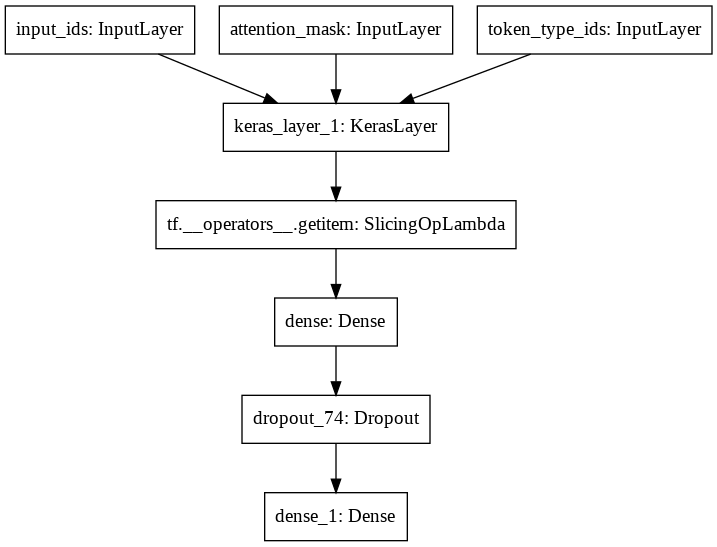

In [32]:
tf.keras.utils.plot_model(model)

In [33]:
# First train only the last layers

bert_model.trainable = False
model.compile(loss='categorical_crossentropy', 
             optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), 
             metrics=['accuracy'])

In [34]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)

train_history = model.fit(
    input_x, train_labels, 
    validation_split=0.1,
    epochs=5,
    #callbacks=[checkpoint],
    batch_size=32,
    verbose=1)

Epoch 1/5
47/47 [==============================] - 28s 378ms/step - loss: 1.3610 - accuracy: 0.2310 - val_loss: 1.2172 - val_accuracy: 0.2866
Epoch 2/5
47/47 [==============================] - 15s 320ms/step - loss: 1.2527 - accuracy: 0.3171 - val_loss: 1.0882 - val_accuracy: 0.4451
Epoch 3/5
47/47 [==============================] - 15s 315ms/step - loss: 1.1508 - accuracy: 0.3989 - val_loss: 0.9952 - val_accuracy: 0.5427
Epoch 4/5
47/47 [==============================] - 15s 312ms/step - loss: 1.0775 - accuracy: 0.4299 - val_loss: 0.9297 - val_accuracy: 0.5671
Epoch 5/5
47/47 [==============================] - 15s 312ms/step - loss: 1.0144 - accuracy: 0.4901 - val_loss: 0.8770 - val_accuracy: 0.6220


In [35]:
# Unfreeze the BERT model for fine-tuning

bert_model.trainable = True
model.compile(loss='categorical_crossentropy', 
             optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), 
             metrics=['accuracy'])

checkpoint = tf.keras.callbacks.ModelCheckpoint('greek_bert_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)

train_history = model.fit(
    input_x, train_labels, 
    validation_split=0.1,
    epochs=5,
    #callbacks=[checkpoint],
    batch_size=32,
    verbose=1)

Epoch 1/5
47/47 [==============================] - 53s 844ms/step - loss: 0.7843 - accuracy: 0.6598 - val_loss: 0.7090 - val_accuracy: 0.6768
Epoch 2/5
47/47 [==============================] - 37s 781ms/step - loss: 0.5620 - accuracy: 0.7892 - val_loss: 0.7289 - val_accuracy: 0.6951
Epoch 3/5
47/47 [==============================] - 37s 781ms/step - loss: 0.4200 - accuracy: 0.8466 - val_loss: 0.7078 - val_accuracy: 0.7134
Epoch 4/5
47/47 [==============================] - 37s 785ms/step - loss: 0.3420 - accuracy: 0.8910 - val_loss: 0.6475 - val_accuracy: 0.7256
Epoch 5/5
47/47 [==============================] - 37s 782ms/step - loss: 0.3166 - accuracy: 0.8822 - val_loss: 0.6413 - val_accuracy: 0.7500


In [36]:
# Do an inference with a random input

# 0 = 'Negative'
# 1 = 'Positive'
# 2 = 'Neutral'

input_test = bert_encode(['Επιχείρηση Βολευτική έδρα!  Βασίλης Οικονόμου:  Από το ΠΑΣΟΚ διαγράφηκε απο το ΓΑΠ επειδη ΔΕΝ ψήφισε το Μνημόνιο...'], bert_preprocess_model)
print(input_test)
output = model(input_test)
print()
print(np.array(output[0]))

(array([[  101,  1314, 16357,   668,  1351,   108,  3113, 12078,   143,
          352,   345,  1609,  5294,   956,   352,   345, 18408,   593,
          366, 11598,   345,  3818,   121,   121,   121,   102,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
     

In [37]:
# Save model 

save_path = "content/model_final"
tf.saved_model.save(model, save_path)

In [38]:
# In case you come later load the model from saved_model folder

new_model = tf.keras.models.load_model('content/model_final')

# Check its architecture
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 128)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
token_type_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
keras_layer_1 (KerasLayer)      {'pooler_output': (N 112921344   input_ids[0][0]                  
                                                                 attention_mask[0][0]         